# Individual glacier analysis 2

This notebook will demonstrate the workflow for reading in glacier outlines (vector data) and glacier velocity (raster data) for a large region, extracting the data to examine an individual glacier and performing some preliminary analysis of glacier surface velocities at the scale of an individual glacier

We start by installing the necessary software:

In [16]:
import xarray as xr
from skimage.morphology import skeletonize
from shapely.geometry import MultiPolygon
import geopandas as gpd
import rioxarray as rxr
import numpy as np
from matplotlib import pyplot as plt

Set paths (hopefully move away from this once accessing data from cloud)

In [17]:
gen_path = '/Users/emarshall/Desktop/siparcs/data/'
rgi_path = '/Users/emarshall/Desktop/siparcs/data/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'

In [ ]:
gen_path_home = '/Users/emmamarshall/Desktop/phd_research/siparcs/'
rgi_path_home = '/Users/emmamarshall/Downloads/15rgi60SouthAsiaEast'

## Read in raster data

In this example, we'll again by using ITS_LIVE ice velocity data downloaded from the NSIDC DAAC access point (for now)

In [18]:
itslive = rxr.open_rasterio(gen_path + 'HMA_G0120_0000.nc').squeeze()

What CRS is this dataset in?

In [19]:
itslive.rio.crs

CRS.from_wkt('PROJCS["Asia_North_Lambert_Conformal_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["false_easting",0],PARAMETER["false_northing",0],PARAMETER["central_meridian",95],PARAMETER["standard_parallel_1",15],PARAMETER["standard_parallel_2",65],PARAMETER["latitude_of_origin",30],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","102027"]]')

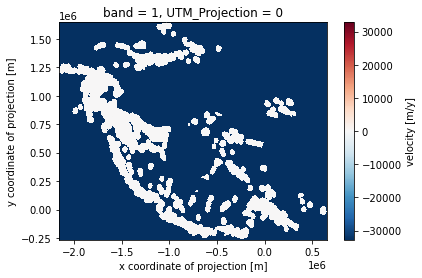

In [39]:
itslive.v.plot()

In [37]:
itslive.v.UTM_Projection.GeoTransform

'-2160007.5 120.0 0.0 1643527.5 0.0 -120.0'

It looks like the ITS_LIVE data is in the Asia North Lambert Conformal Conic coordinate reference system. When we read in the vector data and begin to work with it we will need to project it to match this.

## Read in vector data

The glacier outline and attribute data we will be using is from the Randolph Glacier Inventory (RGI). The RGI contains data for glaciers worldwide and is divided into 19 primary regions. We will read in one region (South Asia East) here. 

In [20]:
#se_asia = gpd.read_file(gen_path_home[:-9] + 'data/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp')
se_asia = gpd.read_file(rgi_path)


And let's explore this data a bit by looking at:
- the number of glaciers within the dataset
- the spatial extent of the dataset
- the coordinate reference system of the dataset


In [21]:
print('Number of glaciers in dataset: ', len(se_asia['RGIId']))

Number of glaciers in dataset:  13119


<AxesSubplot:>

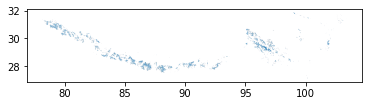

In [22]:
se_asia.plot()

In [ ]:
print('CRS: ', se_asia.crs)

The RGI glacier outline dataframe is in lat/lon so let's project it to match the raster data:
If you look at the geoemtry column of the projected dataset you will see that the coordinates are now in meters instead of degrees.

In [23]:
se_asia_prj = se_asia.to_crs('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs')
se_asia_prj

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00001,G102044E29941N,19990920,-9999999,102.044042,29.941000,15,3,0.438,4996,...,251,850,0,0,0,0,9,9,None,"POLYGON ((626747.322 19334.286, 626747.214 193..."
1,RGI60-15.00002,G102042E29987N,19990920,-9999999,102.042346,29.987019,15,3,0.644,4947,...,244,1021,0,0,0,0,9,9,None,"POLYGON ((626699.144 24673.098, 626701.110 246..."
2,RGI60-15.00003,G102041E29997N,19990920,-9999999,102.041130,29.997311,15,3,0.225,5019,...,274,812,0,0,0,0,9,9,None,"POLYGON ((626205.858 25396.784, 626210.489 254..."
3,RGI60-15.00004,G102050E29962N,19990920,-9999999,102.050283,29.962297,15,3,0.985,4622,...,52,2318,0,0,0,0,9,9,None,"POLYGON ((627054.150 21582.052, 627057.905 216..."
4,RGI60-15.00005,G102044E30025N,19990920,-9999999,102.043728,30.025101,15,3,0.465,4733,...,20,913,0,0,0,0,9,9,None,"POLYGON ((626913.162 28267.766, 626895.820 282..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13114,RGI60-15.13115,G081977E30337N,20090918,-9999999,81.977000,30.337000,15,1,1.356,5480,...,352,1856,0,0,0,0,9,9,CN5Z342A0003,"POLYGON ((-1150121.533 121963.660, -1150118.27..."
13115,RGI60-15.13116,G081991E30339N,20090918,-9999999,81.991000,30.339000,15,1,7.427,5266,...,330,5779,0,0,0,0,9,9,CN5Z342A0003,"POLYGON ((-1148353.222 121707.808, -1148328.34..."
13116,RGI60-15.13117,G081355E30440N,20070912,-9999999,81.355000,30.440000,15,1,6.788,5696,...,96,5519,0,0,0,0,9,9,CN5Z342B0006,"POLYGON ((-1204224.276 142125.331, -1204220.83..."
13117,RGI60-15.13118,G081361E30451N,20070912,-9999999,81.361000,30.451000,15,1,0.043,5969,...,206,527,0,0,0,0,9,9,None,"POLYGON ((-1202593.561 141849.818, -1202579.07..."


## Clipping raster data by a vector

Now, let's focus on just a single glacier. To start with, let's look at the five largest (in area) glaciers in the dataset and choose one of those.

In [24]:
se_asia.sort_values(by = 'Area', ascending=False).head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
11908,RGI60-15.11909,G096657E29334N,20050908,-9999999,96.657000,29.334000,15,3,179.589,3980,...,78,32403,0,0,1,0,1,9,Yagnung,"POLYGON ((96.57583 29.39731, 96.57590 29.39730..."
6880,RGI60-15.06881,G079147E30802N,20010801,-9999999,79.147205,30.801627,15,1,121.890,3999,...,353,32048,0,0,0,0,9,0,Gangotri Glacier,"POLYGON ((79.17425 30.82318, 79.17372 30.82337..."
11925,RGI60-15.11926,G096745E29216N,20050908,-9999999,96.745000,29.216000,15,3,96.283,4285,...,101,15157,0,0,1,0,9,9,CN5O282B0028 Xirinongpu Glacier,"POLYGON ((96.73404 29.26991, 96.73484 29.26927..."
9990,RGI60-15.09991,G086830E28048N,20100409,-9999999,86.830000,28.048000,15,2,73.215,5155,...,13,20118,0,0,0,0,9,9,CN5O193B0142 Rongbuk Glacier,"POLYGON ((86.87850 28.06345, 86.87983 28.06234..."
2702,RGI60-15.02703,G088202E27766N,20001108,-9999999,88.201782,27.765869,15,2,68.664,4187,...,69,26217,0,0,0,0,9,9,None,"POLYGON ((88.25193 27.80569, 88.25205 27.80544..."


To start with, let's look at the glacier with the RGIId RGI60-15.11926 and an area of 96.283 km2. 

In [25]:
rgi11926 = se_asia_prj.loc[se_asia_prj['RGIId'] == 'RGI60-15.11926']
rgi11926

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
11925,RGI60-15.11926,G096745E29216N,20050908,-9999999,96.745,29.216,15,3,96.283,4285,...,101,15157,0,0,1,0,9,9,CN5O282B0028 Xirinongpu Glacier,"POLYGON ((155971.052 -73238.820, 156044.377 -7..."


In [26]:
raster_11926 = itslive.rio.clip(rgi11926.geometry, rgi11926.crs)

In [27]:
#turn non-ice pixels to NaN (previously -32767.)
clipped_raster11926 = xr.where(raster_11926.ice == 1., raster_11926, np.NaN)

## Extract glacier centerline

- using scikit-image skeletonize()
- probably not the best/ideal way to do this, for now wanted to have an example but maybe not worth including here? 

In [28]:
def extract_glacier_centerline(glacier_gpdf, full_scene_raster):
    ''' This function should take in a vector outline of a single glacier and a xr object of glacier velocity data (full scene) 
    and return a dictionary (?) with 2 keys and values corresponding to two xarray objects: one showing the full 2d extent of 
    raster data clipped to the glacier outline and one with the extracted glacier centerline'''

    #clip raster by vector
    clipped_raster = full_scene_raster.rio.clip(glacier_gpdf.geometry, glacier_gpdf.crs)

    #turn non-ice pixels to NaN (previously -32767.)
    clipped_raster = xr.where(clipped_raster.ice == 1., clipped_raster, np.NaN)

    #extract centerline - this is a xr DataArray that only has an boolean array representing centerline
    centerline_da = clipped_raster.ice.reduce(skeletonize)

    #create xarray dataset with centerline extracted for all data vars
    centerline_ds = clipped_raster.where(centerline_da != False)

    #wrap into dict
    glacier_dict = {'clipped_to_ice': clipped_raster,
                    'centerline': centerline_ds
                    }

    return glacier_dict

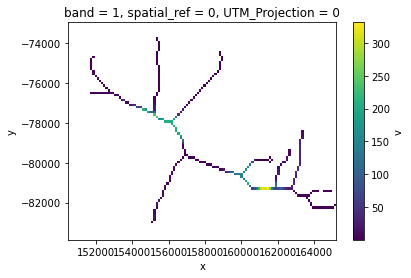

In [29]:
g11926_dict = extract_glacier_centerline(rgi11926, itslive)
g11926_cl = g11926_dict['centerline']
g11926_cl.v.plot()

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize= (14,7))

g11926_cl.v.plot(ax=axs[0])
g11926_dict['clipped_to_ice'].v.plot(ax=axs[1])

In [ ]:
g06681_dict = extract_glacier_centerline(rgi06681, itslive)

### non-function examples below

In [ ]:
centerline_11926_da = clipped_raster11926.ice.reduce(skeletonize)
centerline_11926_da.plot()
type(centerline_11926_da)

In [ ]:
centerline_11926_ds = clipped_raster11926.where(centerline_11926_da != False)
centerline_11926_ds.v.plot()

In [ ]:
g11926_dict = {'full':raster_11926,
                'clipped_to_ice': clipped_raster11926,
                'centerline': centerline_11926_ds}

In [ ]:
g11926_dict = extract_glacier_centerline(rgi11926, itslive)
g11926_cl = g11926_dict['centerline']
g11926_cl.v.plot()

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize= (14,7))

g11926_cl.v.plot(ax=axs[0])
g11926_dict['clipped_to_ice'].v.plot(ax=axs[1])

In [ ]:
g06681_dict = extract_glacier_centerline(rgi06681, itslive)

In [ ]:
g06681_dict.keys()

In [ ]:
g06681_cl = g06681_dict['centerline']
g06681_cl.v.plot()

In [ ]:
rgi06681 = se_asia_prj.loc[se_asia_prj['RGIId'] == 'RGI60-15.06681']
se_asia_prj.sort_values('Area', ascending=False).head()

### A second glacier

In [ ]:
rgi11909 = se_asia_prj.loc[se_asia_prj['RGIId'] == 'RGI60-15.11909']
rgi11909

In [ ]:
raster_11909 = itslive.rio.clip(rgi11909.geometry, rgi11909.crs)

In [ ]:
#turn non-ice pixels to NaN ()
clipped_raster11909 = xr.where(raster_11909.ice == 1., raster_11909, np.NaN)

Compare different skeletonize algorithms:

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize = (14,4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(just_ice.v, cmap=plt.cm.cividis)
ax[0].axis('off')
ax[0].set_title('Glacier velocity', fontsize=14)
ax[0].imshow(skeleton_ice, cmap=plt.cm.Reds, alpha = 0.2)
ax[0].imshow(skeleton_ice_lee, cmap=plt.cm.Greens, alpha = 0.2)


ax[1].imshow(skeleton_ice, cmap=plt.cm.Reds)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=14)

ax[2].imshow(skeleton_ice_lee, cmap=plt.cm.Greens)
ax[2].axis('off')
ax[2].set_title('skeleton (lee)', fontsize=14)

fig.tight_layout()
fig.show

## Make xarray object out of centerline bool mask
- should have the same coords as the velocity xarray object

In [ ]:
centerline_da = xr.DataArray(
    skeleton_ice,
    dims=("y", "x"),
    coords={
        "x": glacier_raster.coords['x'].data,
        "y": glacier_raster.coords['y'].data}
)


centerline_da.plot()

In [ ]:
centerline_da

### Extract itslive xarray dataset data only at points along centerline
- this should return a dataset with the same data vars but only data along centerline

In [ ]:
centerline_ds = glacier_raster.where(da != False)

In [ ]:
centerline_ds

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize=(20,8))
just_ice.ice.plot(ax=axs[0], cmap=plt.cm.cividis)
centerline_ds.v.plot(ax=axs[0])

just_ice.v.plot(ax=axs[1])

### Experimenting with skeletonize v. thin (scikit image)

In [ ]:
just_ice.ice.plot()

In [ ]:
from skimage.morphology import skeletonize, thin

thinned = thin(just_ice.ice)
#thinned_partial = thin(just_ice.ice.data, max_num_iter = 50)

plt.imshow(thinned)

In [ ]:
fig, axs = plt.subplots(ncols=2)

axs[0].imshow(thinned, cmap=plt.cm.gray)
axs[0].set_title('thinned')
axs[0].axis('off')

axs[1].imshow(thinned_partial, cmap=plt.cm.gray)
axs[1].set_title('thinned partial')
axs[1].axis('off')

